<a href="https://colab.research.google.com/github/unoki/colabtest/blob/master/2_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第２章　高速フーリエ変換による周波数分析（プログラム）

第２章では、Numpyライブラリに含まれる高速フーリエ変換（FFT）モジュールを用いて、周波数分析を行います。

周波数分析は、周期性のあるデータの概要把握に役に立ちます。周波数分析の結果はニューラルネットワークの特徴量として利用することができます。機械学習の精度を上げるためるために、時系列データのノイズ除去や特定の周波数範囲のデータを削除するフィルター処理は有効です。

難しい数式展開を知らなくても、Pythonを使えば簡単に周波数分析ができることを体感してください。
本章では、Matplolibを使った可視化のテクニックについても紹介します。


### 学習項目

1. 準備
2. データの読み込みと確認
3. 高速フーリエ変換（FFT）
4. 逆フーリエ高速変換（IFFT）
5. ローパスフィルター
6. ピークの検出と可視化


### 使用するファイル
- 2_FFT.ipynb （このファイルです）
- data/fft.csv (データファイル)

### データ
- 練習用に作成した波形データです。
- サンプリング周波数は100Hzで、256点のサンプルが含まれています。すなわち、10ms間隔（１秒あたり100個)で、2.56秒分のデータからなります。
- csvファイルの1列目は最初のサンプルを０秒とした時刻、2列目は対応する時刻の値です。
<br>


      
# 1. 準備
###  必要なライブラリの読み込み

- Pandas：csvファイルの読み込みに使います。
- NumPy：FFTの機能を使います。
- Matplotlib：グラフ描画ライブラリです。データの可視化に使います。Pandasのplotよりも細かい指定ができます。
- SciPy：高水準の科学技術計算ライブラリです。SciPyに含まれるSignalパッケージを使ってピーク値の検出を行います。


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import signal

### グラフのデフォルト表示サイズの変更
セミナー中に画面をプロジェクターに投影するため、図の大きさを大きく変更しています。通常は不要です。

※ 以後の章でも断りなく同様の設定変更を行います。

In [0]:
mpl.rcParams['figure.figsize'] = 14, 4

### カレントディレクトリの移動
- 本セミナーでは、データの保存場所としてGoogle Driveを利用します。
- Google Driveをマウントし、
- 相対パスとしてデータにアクセスできるように、カレントディレクトリを移動しておきます。
- Google Driveを使わない場合には、このセルをコメントアウトしてください。

※ 以後の章でも断りなく同様のカレントディレクトリの移動を行います。

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Colab Notebooks/jasla_rensyuu_20190202"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/jasla_rensyuu_20190202




# 2. データの読み込みと確認

### CSVファイルからデータを読み込む
- csvファイルから Pandas の DataFrame としてデータを読み込みます。
- read_csv 関数を使います。
- パラメータとして、ファイル名を指定します。
- 変数 df に、データを読み込んでみましょう。
- csvファイルの１列目はDataFrameのindexとします。index_colパラメータで指定します。

In [0]:
df = pd.read_csv('data/fft.csv',  index_col=0)

### データのサイズの確認

- データの行と列の数を確認するには、shape を使います。
- shapeは関数ではないので、カッコが不要です。

In [0]:
df.shape

(256, 1)

- 読み込んだデータがSeriesではなく、1列のデータからなるDataFrameであることに注意が必要です。

### データの一部を表示

- データの一部を表示するには、head関数や、tail関数を使います。
- head関数とtail関数は、表示する行数を引数にとります。（デフォルト値:5）

In [0]:
df.head()

,f
0.00,0.000000
0.01,2.058819
0.02,3.062188
0.03,2.640429
0.04,1.291919


### グラフの表示

- matplotlibライブラリのpyplotモジュールに含まれるplotメソッドを使います。
- matplotlib.pyplotは、pltという名前でimportしていました。
- plot関数にDataFrameを渡します。

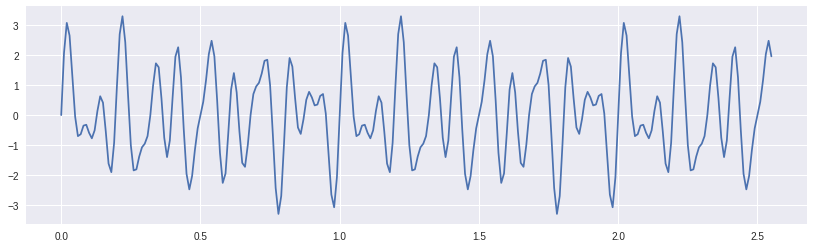

In [0]:
plt.plot(df)


######  （メモ）可視化ライブラリについて
本セミナーシリーズでは、2018年1月にはSeabornを、2018年12月にはPandasのplot関数を中心に紹介しました。今回は主にmatplotlibを使います。Seabornは機能豊富です。Pandas plotはDataFrameの可視化がとてもお手軽にできます。matplotlibは初学者にとってとっつきにくい部分がありますがPandasのplotよりもグラフの体裁を細かく指定できます。



# 3. 高速フーリエ変換（FFT）

###  FFTの実行

- numpyライブラリに含まれるfftモジュールのfft関数を使います。 (https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.fft.fft.html)
- FFTの処理結果は、numpyのndarrayで、値は複素数で取得できます。
- FFTでは、データの個数を2のn乗個にする必要があります。



In [0]:
F = np.fft.fft(df['f']) 

### FFTの出力結果から絶対値を求め、振幅のスケールを合わせる

- 結果を確認するためには、絶対値を求め複素数を実数に変換します。
- 信号の振幅のスケールに合わせるために、データの数で割って２倍します。
- 絶対値の計算には、numpyのabs関数を使います。

In [0]:
F_abs = np.abs(F[:F.size]) / df.size * 2

### 結果をグラフで表示

- matplotlibのplot関数を使って、結果を表示してみます。
- matplotlibでは軸のラベルを指定することができます。
    - 横軸のラベルは、xlabelで指定します。
    - 縦軸のラベルは、ylabelで指定します。
    - フォントのサイズも指定できます。
- 横軸を周波数にしましょう。
    - FFTは、サンプリング周波数までの値が出力されます。
    - 横軸の値を決めるため、numpyのlinspace関数で、等差数列を作ります。
    - linspace関数には、パラメータとして(数列の始点, 数列の終点,分割数)を指定します。

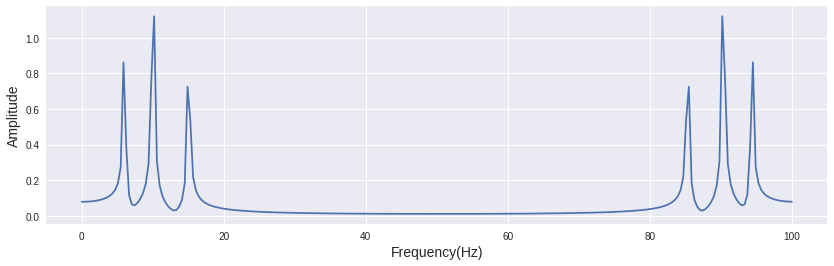

In [0]:
plt.xlabel('Frequency(Hz)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
fq = np.linspace(0, 100, df.size)
plt.plot(fq, F_abs)

### 有効範囲のみを表示する

- FFTの結果の有効範囲は、サンプリング周波数の1/2までです。
- サンプリング周波数の1/2の値を、ナイキスト周波数と呼びます。
- FFTにより得られる結果は、ナイキスト周波数を境に左右対称となります。
- 右半分を左半分の虚像とよび、無視する必要があります。

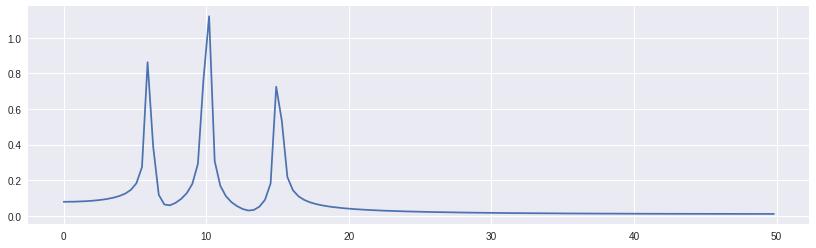

In [0]:
N = int(F_abs.size / 2)
plt.plot(fq[:N], F_abs[:N])

以上で、時間領域の信号を、周波数領域に変換することができました。元の波形は、３つの周波数の正弦波から構成されていることが分かりました。



# 4. 逆フーリエ高速変換（IFFT）

FFTの結果に対して逆フーリエ高速変換（IFFT）を行うことで元の波形に戻すことができるか、確認してみましょう。

###  逆FFTの実行
- numpyライブラリに含まれるfftモジュールのifft関数を使います。 (https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.fft.ifft.html)
- FFTの結果をそのままifft関数に渡して逆FFTをしてみましょう。
- IFFTの結果は、複素数で戻ってきます。
- 実部を取り出してプロットしてみましょう。実部は.realプロパティで取得することができます。

In [0]:
fi = np.fft.ifft(F)
fi_real = fi.real

### 結果をグラフで表示

- matplotlibのplot関数を使って、結果を表示してみます。
- 横軸は時間です。単位を秒にしましょう。

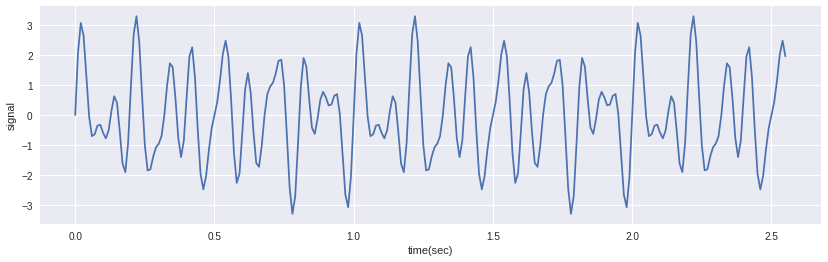

In [0]:
plt.xlabel('time(sec)')
plt.ylabel('signal')
t = np.arange(0, fi_real.size/100, 1/100) # 時間軸を秒にする
plt.plot(t, fi_real)

FFTの結果を逆FFTすることで、元の波形とほぼ同じ形に戻ることが分かりました。

# 5. ローパスフィルター

FFTの結果（周波数領域）から、指定した値より高い周波数のデータカットします。カット後のデータを逆FFTをし、先ほどの結果と比べてみましょう。

###  データの書き換え
- 閾値を変数fcに設定します。ここでは8Hzとしました。
- 元のデータを残しておきたいので、FFTの結果Fを別な変数F1にコピーします。
- fcよりも高い周波数のデータをゼロに書き換えます。

In [0]:
fc = 8 
F1 = F.copy()
F1[(fq > fc)] = 0

###  逆FFTの実行
- numpy.fft.ifft関数を使います。
- 実部を取り出して振幅を元のスケールに戻します。すでに虚像をカットしているのでスケールを合わせるために値を2倍にします。

In [0]:
F_ifft = np.fft.ifft(F1) 
F_ifft_real = F_ifft.real * 2 

### 結果をグラフで表示

- matplotlibのplotを使って、結果を表示してみます。
- 横軸は時間です。単位を秒にしましょう。

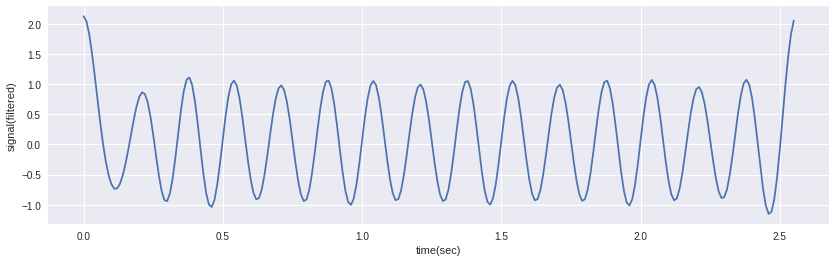

In [0]:
t = np.arange(0, F_ifft_real.size/100, 1/100) # 時間軸を秒にする
plt.xlabel('time(sec)')
plt.ylabel('signal(filtered)')
plt.plot(t, F_ifft_real)

# 6. ピークの検出と可視化

SciPyのsignalパッケージにはピーク（極大、極小）を自動で検出する便利な機能があります。検出されたピーク値をmatplotlibのアノテーションを使って可視化してみましょう。

### ピークの検出
- signal.argrelmax関数で極大値が、signal.argrelmin関数で極小値のインデックスが取得できます
- 今回は、signal.argrelmax関数を使って、極大値を検出してみましょう。
- orderパラメータで検出の際に比較をする両側のデータの範囲を指定できます。
- 結果を変数max_idxに代入しましょう。
- 結果はndarrayのtupleで戻ってきます。ndarrayとして取り出すため[0]を付けています。

In [0]:
max_idx = signal.argrelmax(F_abs, order=1)[0]

# 虚像(後半)を除外
max_idx = max_idx[ (max_idx <= 100/2)]

### 結果をグラフで表示

- matplotlibのplotを使って、結果を表示します。
- annotate関数でアノテーションをつけることができます。ピークに周波数をテキストで表示してみました。
(https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html)

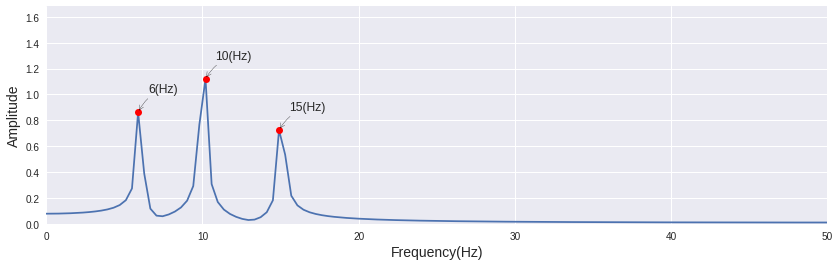

In [0]:
plt.xlabel('Frequency(Hz)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

plt.axis([0, 100/2,0, max(F_abs)*1.5])
plt.plot(fq, F_abs)
plt.plot(fq[max_idx], F_abs[max_idx],'ro')

# グラフにピークの周波数をテキストで表示
for i in range(len(max_idx)):
    plt.annotate('{0:.0f}(Hz)'.format(np.round(fq[max_idx[i]])),
                 xy = (fq[max_idx[i]], F_abs[max_idx[i]]),
                 xytext = (10, 20),
                 textcoords = 'offset points',
                 arrowprops = dict(arrowstyle="->",
                                   connectionstyle="arc3,rad=.2")
                )